✅ Parsed 8 input vectors (latest batch only).
✅ Parsed 8 outputs (latest batch only).

=== Function 1 (2D) ===
  Data size: 14, Output range: [-0.0036, 64.0000]


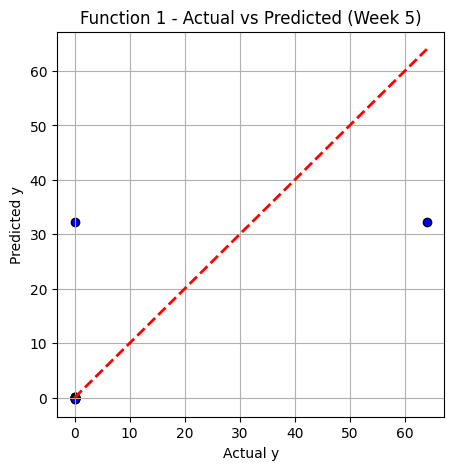

  Best predicted output: 32.5321
  Query to submit: 0.170683-0.574371

=== Function 2 (2D) ===
  Data size: 14, Output range: [-0.0656, 3.1124]


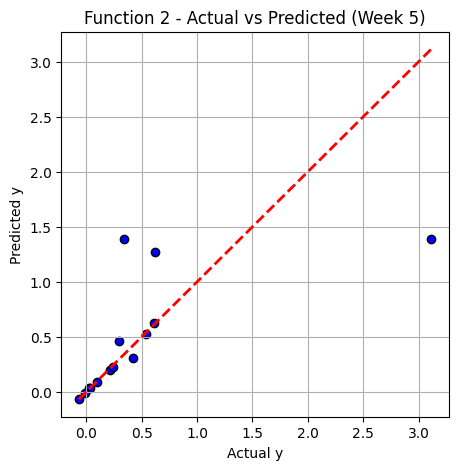

  Best predicted output: 1.3893
  Query to submit: 0.741163-0.724273

=== Function 3 (3D) ===
  Data size: 19, Output range: [-0.3989, 71.0000]


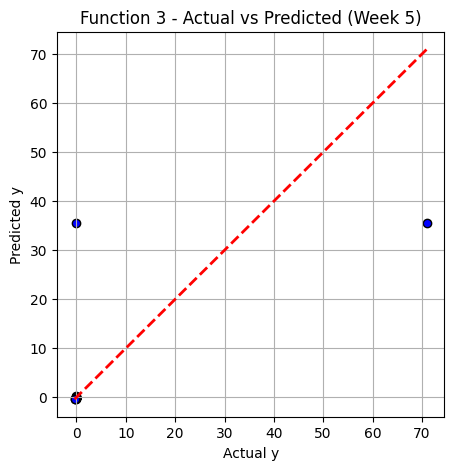

  Best predicted output: 33.9543
  Query to submit: 0.180847-0.634711-0.840486

=== Function 4 (4D) ===
  Data size: 34, Output range: [-32.6257, 64.0000]


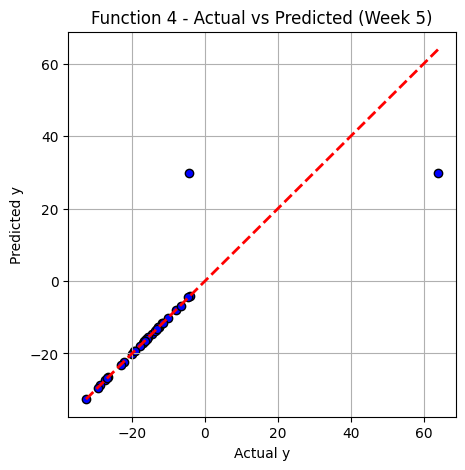

  Best predicted output: 30.5797
  Query to submit: 0.037726-0.268093-0.266917-0.348620

=== Function 5 (4D) ===
  Data size: 24, Output range: [0.1129, 1787.3908]


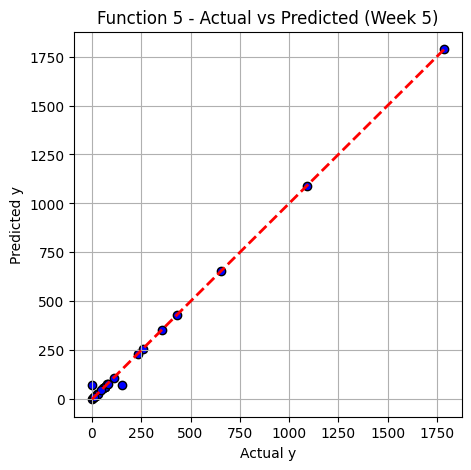

  Best predicted output: 1687.2144
  Query to submit: 0.069592-0.977511-0.915373-0.974416

=== Function 6 (5D) ===
  Data size: 24, Output range: [-2.5712, 64.0000]


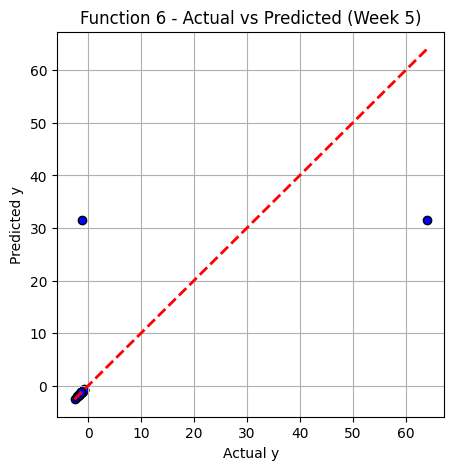

  Best predicted output: 32.8815
  Query to submit: 0.510550-0.071191-0.010887-0.731474-0.195301

=== Function 7 (6D) ===
  Data size: 34, Output range: [-0.0787, 1.3650]


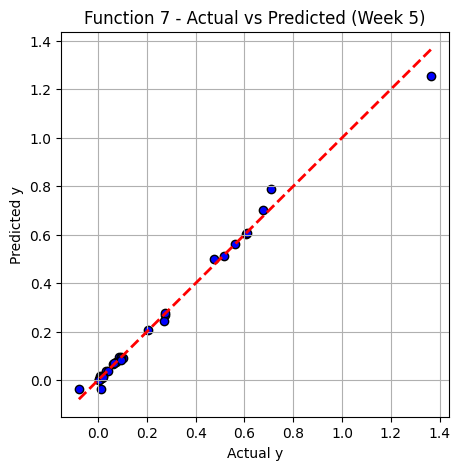

  Best predicted output: 1.1266
  Query to submit: 0.085698-0.315418-0.182611-0.239362-0.382200-0.763591

=== Function 8 (8D) ===
  Data size: 44, Output range: [5.5922, 64.0000]


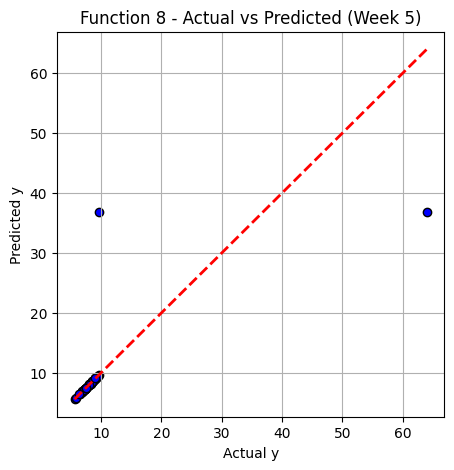

  Best predicted output: 31.9370
  Query to submit: 0.097254-0.555509-0.160490-0.777258-0.199240-0.996786-0.131261-0.981104

💾 Saved all week5 queries to week5_queries.txt


In [6]:
import numpy as np
import os
import re
import ast
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# =========================
# CONFIGURATION
# =========================
base_path = "data/"
inputs_txt = "week4/inputs.txt"       # dari email terbaru (berisi semua batch)
outputs_txt = "week4/outputs.txt"
n_candidates = 3000

# =========================
# LOAD INPUTS (ambil batch terakhir)
# =========================
def load_inputs(path):
    with open(path, "r") as f:
        text = f.read().strip()

    # Pecah per batch berdasarkan baris kosong / newline antar blok
    batches = re.split(r"\]\s*\n\s*\[", text)
    last_batch = "[" + batches[-1].strip().lstrip("[").rstrip("]") + "]"

    # Bersihkan array() dan konversi ke list numpy
    last_batch = re.sub(r'array\(', '', last_batch).replace(')', '')
    chunks = re.findall(r'\[([^\[\]]+)\]', last_batch)

    vectors = []
    for ch in chunks:
        nums = [float(x) for x in ch.split(",") if x.strip()]
        vectors.append(np.array(nums))
    print(f"✅ Parsed {len(vectors)} input vectors (latest batch only).")
    return vectors

# =========================
# LOAD OUTPUTS (ambil batch terakhir)
# =========================
def load_outputs(path):
    """Safely load outputs.txt (handles np.float64 and nested brackets)."""
    with open(path, "r") as f:
        text = f.read().strip()

    # Pisah antar batch berdasarkan newline antar blok
    batches = re.split(r"\]\s*\n\s*\[", text)
    last_batch = batches[-1].strip()

    # Bersihkan karakter sisa
    last_batch = last_batch.replace("np.float64(", "").replace(")", "")
    last_batch = last_batch.replace("[", "").replace("]", "")
    last_batch = re.sub(r"[^\deE\-\.\,\s]", "", last_batch)  # hapus simbol aneh

    # Ambil semua angka float
    numbers = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", last_batch)
    outputs = np.array([float(x) for x in numbers], dtype=float)

    print(f"✅ Parsed {len(outputs)} outputs (latest batch only).")
    return outputs

# =========================
# LOAD DATA
# =========================
new_inputs = load_inputs(inputs_txt)
new_outputs = load_outputs(outputs_txt)

# =========================
# BUILD MODEL (WEEK 5)
# =========================
queries_out = []
for i in range(1, 9):
    folder = os.path.join(base_path, f"function_{i}")
    input_file = os.path.join(folder, "week4_inputs.npy")
    output_file = os.path.join(folder, "week4_outputs.npy")

    # Gabungkan data lama + minggu ini
    X_prev = np.load(input_file)
    y_prev = np.load(output_file)
    X_combined = np.vstack([X_prev, new_inputs[i-1].reshape(1, -1)])
    y_combined = np.append(y_prev, new_outputs[i-1])

    np.save(os.path.join(folder, "week5_inputs.npy"), X_combined)
    np.save(os.path.join(folder, "week5_outputs.npy"), y_combined)

    dim = X_combined.shape[1]
    print(f"\n=== Function {i} ({dim}D) ===")
    print(f"  Data size: {len(X_combined)}, Output range: [{y_combined.min():.4f}, {y_combined.max():.4f}]")

    # Neural surrogate (deep)
    model = make_pipeline(
        StandardScaler(),
        MLPRegressor(
            hidden_layer_sizes=(128, 64, 32),
            activation='relu',
            solver='adam',
            learning_rate_init=0.001,
            max_iter=2000,
            random_state=42
        )
    )
    model.fit(X_combined, y_combined)
    import matplotlib.pyplot as plt

    # Plot actual vs predicted pada data training
    y_pred_train = model.predict(X_combined)
    
    plt.figure(figsize=(5, 5))
    plt.scatter(y_combined, y_pred_train, c='blue', edgecolor='k')
    plt.plot([y_combined.min(), y_combined.max()],
             [y_combined.min(), y_combined.max()],
             'r--', lw=2)
    plt.title(f'Function {i} - Actual vs Predicted (Week 5)')
    plt.xlabel('Actual y')
    plt.ylabel('Predicted y')
    plt.grid(True)
    plt.show()
    # Candidate search
    candidates = np.random.uniform(0, 1, (3000, dim))
    preds = model.predict(candidates)
    best_idx = np.argmax(preds)
    best_query = np.clip(candidates[best_idx], 0.0, 1.0)
    query_str = "-".join([f"{x:.6f}" for x in best_query])

    print(f"  Best predicted output: {preds[best_idx]:.4f}")
    print(f"  Query to submit: {query_str}")
    queries_out.append(f"Function {i}: {query_str}")

# =========================
# SAVE WEEK5 QUERIES
# =========================
with open("week5_queries.txt", "w") as f:
    f.write("\n".join(queries_out))
print("\n💾 Saved all week5 queries to week5_queries.txt")